# Travel Insurance Claim Detection System


## Business Understanding

**Context**  

Sebuah perusahaan yang bergerak di bidang Asuransi Perjalanan ingin mengetahui pemegang polis yang akan mengajukan klaim asuransi atas pertanggungan. Lebih dari itu perusahaan asuransi juga bertugas untuk menanggung resiko customer, sehingga risk management merupakan aspek penting dalam industri asuransi.

Data pemegang polis di perusahaan asuransi merupakan data historis, terdiri dari destinasi, produk asuransi, dan sebagainya.

**Problem Statement :**

>Apakah nasabah/customer akan melakukan claim atau tidak?

**Goals :**

- Melakukan prediksi terhadap customer akan claim atau tidak
- Memaksimalkan penjualan polis untuk product yang jarang di claim

**Analytic Approach :**

Melakukan analisa data untuk menemukan pola yang membedakan pemegang polis yang mengajukan klaim dan yang tidak mengajukan klaim. 

Selanjutnya, membangun model deteksi yang akan membantu perusahaan untuk dapat memprediksi probabilitas seorang pemegang polis akan mengajukan klaim asuransi atau tidak

**Metric Evaluation**

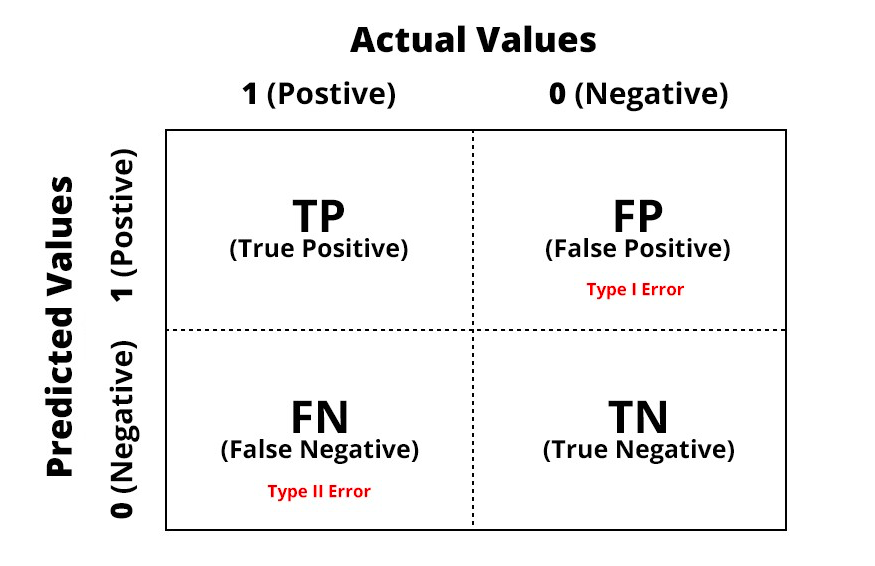

**Errors**

1. Type 1: False Positive di prediksi claim ternyata tidak claim 
Konsekuensi: Persiapan dana pencairan akan sia-sia karena tidak tepat sasaran dan tidak tepat jumlah (idle cash)

1. Type 2: False Negative di prediksi tidak claim ternyata claim  
Konsekuensi: Loss revenue

Berdasarkan konsekuensinya, maka sebisa mungkin yang akan kita lakukan adalah membuat model deteksi yang dapat meminimalisir (menurunkan) tingkat False Negative. 

sehingga metric utama yang akan digunakan adalah recall score.

## Data Understanding

Dataset source : [Data Travel Insurance](https://drive.google.com/file/d/1emDTGFvku7UuuVT3W-EmEvg3i61QrIU-/view)

Note : 
- Dataset tidak seimbang
- Terdapat fitur-fitur bersifat kategori dan numerik
- Setiap baris data merepresentasikan informasi seorang pemegang polis dengan data riwayat perjalanan

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
uploaded = files.upload()

Saving data_travel_insurance.csv to data_travel_insurance.csv


In [3]:
df = pd.read_csv('data_travel_insurance.csv')
df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


In [4]:
df.shape

(44328, 11)

Data terdiri dari 44328 baris dan 11 kolom

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Commision (in value)  44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


In [6]:
df.isna().sum()

Agency                      0
Agency Type                 0
Distribution Channel        0
Product Name                0
Gender                  31647
Duration                    0
Destination                 0
Net Sales                   0
Commision (in value)        0
Age                         0
Claim                       0
dtype: int64

Dari semua kolom yang ada hanya kolom `Gender` yang memiliki data NaN sebanyak 31647.

In [7]:
dataDesc=[]
for i in df.columns:
    dataDesc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round((((df[i].isna().sum())/len(df))*100),2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values
    ])

pd.DataFrame(dataDesc, columns=[
    'Data Features',
    'Data Types',
    'Null',
    'Null Percentage',
    'Unique',
    'Unique Sample'
])

,Data Features,Data Types,Null,Null Percentage,Unique,Unique Sample
0,Agency,object,0,0.00,16,"[CWT, ART]"
1,Agency Type,object,0,0.00,2,"[Travel Agency, Airlines]"
2,Distribution Channel,object,0,0.00,2,"[Offline, Online]"
3,Product Name,object,0,0.00,26,"[Ticket Protector, Annual Silver Plan]"
4,Gender,object,31647,71.39,2,"[nan, M]"
5,Duration,int64,0,0.00,437,"[33, 189]"
6,Destination,object,0,0.00,138,"[FINLAND, ANGOLA]"
7,Net Sales,float64,0,0.00,1006,"[157.0, 539.0]"
8,Commision (in value),float64,0,0.00,915,"[10.5, 128.75]"
9,Age,int64,0,0.00,89,"[19, 27]"


In [8]:
df['Gender'].unique()

array(['F', nan, 'M'], dtype=object)

71.39% data dalam kolom `Gender` memiliki nilai NaN, sehingga kolom `Gender` ini akan didrop.

In [9]:
df = df.drop('Gender', axis=1)
df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.0,28,No


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Duration,44328.0,49.424292,109.153961,-1.0,9.0,22.0,53.00,4881.0
Net Sales,44328.0,40.550948,48.661970,-357.5,18.0,26.5,48.00,810.0
Commision (in value),44328.0,9.707692,19.625637,0.0,0.0,0.0,11.55,283.5
Age,44328.0,39.925600,13.954926,0.0,35.0,36.0,43.00,118.0


In [11]:
df.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Age',
       'Claim'],
      dtype='object')

In [12]:
df['Claim'].unique()

array(['No', 'Yes'], dtype=object)

Kolom Target `Claim`:
- No : 0
- Yes : 1

Kolom Independen Kategorikal:
- Agency
- Agency Type
- Distribution Channel
- Product Name
- Destination

Kolom Independen Numerikal:
- Duration
- Net Sales
- Commision (in Value)
- Age

### 1. Konversi Kolom Target dari tipe Teks ke Numerik

In [13]:
df['Claim'] = df['Claim'].map({
    'No' : 0,
    'Yes' : 1
})

In [14]:
#cek distribusi data target
df['Claim'].value_counts()

0    43651
1      677
Name: Claim, dtype: int64

Distribusi target terlihat timpang dengan kelas 0 sebanyak 43651 dan kelas 1 sebanyak 677. Hal ini menandakan data nasabah Claim jauh lebih sedikit dibanding data nasabah Non Claim

### 2. Handling Kolom Kategorikal
- Crosstab kolom features kategorikal: `Agency`, `Agency Type`, `Distribution Channel`, `Product Name`, `Destination`
untuk mengetahui presentase data unique dalam masing-masing kolom dan pengaruh terhadap Claim asuransi
- Recategorize kolom kategorikal yang memiliki banyak unique values dan disesuaikan dengan Claim

#### 2.1 Feature `Agency`

In [15]:
(pd.crosstab(index = df['Agency'], columns = df['Claim'], normalize = True)*100).round(3)

Claim,0,1
Agency,,
ADM,0.124,0.000
ART,0.517,0.000
C2B,12.060,0.918
CBH,0.153,0.002
CCR,0.280,0.005
CSR,0.151,0.002
CWT,13.346,0.144
EPX,55.322,0.300
JWT,1.169,0.009


Akan diambil `Agency`: 'C2B', 'CWT', 'EPX', yang mempengaruhi `Claim` kelas 1 sedangkan yang presentasenya kecil akan dikelompokkan menjadi 'Others'

In [16]:
#Recategorize kolom Agency
def recat_agency(x):
    if x in ['C2B', 'CWT', 'EPX']:
        return x
    else:
        return 'Others'
df['Agency'] = df['Agency'].apply(recat_agency)
df['Agency'].unique()

array(['C2B', 'EPX', 'Others', 'CWT'], dtype=object)

In [17]:
df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.0,57,0
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.0,33,0
2,Others,Airlines,Online,Basic Plan,19,INDIA,22.0,7.7,26,0
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.0,59,0
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.0,28,0


In [18]:
(pd.crosstab(df['Agency'], columns = 'Percentage', normalize=True).sort_values('Percentage', ascending = False))*100

col_0,Percentage
Agency,
EPX,55.621729
Others,17.909673
CWT,13.490345
C2B,12.978253


#### 2.2 Feature `Agency Type`

In [19]:
(pd.crosstab(index = df['Agency Type'], columns=df['Claim'], normalize=True)*100).round(3)

Claim,0,1
Agency Type,,
Airlines,26.566,0.990
Travel Agency,71.907,0.537


Semua data di kolom `Agency Type` akan digunakan karena hanya ada 2 tipe

#### 2.3 Feature `Distribution Channel`

In [20]:
(pd.crosstab(index = df['Distribution Channel'], columns = df['Claim'], normalize=True)*100).round(3)

Claim,0,1
Distribution Channel,,
Offline,1.681,0.025
Online,96.792,1.502


Semua data di kolom `Distribution Channel` akan digunakan karena hanya ada 2 tipe

#### 2.4 Feature `Product Name`

In [21]:
(pd.crosstab(index = df['Product Name'], columns = df['Claim'], normalize = True)*100).round(3)

Claim,0,1
Product Name,,
1 way Comprehensive Plan,5.254,0.016
2 way Comprehensive Plan,20.858,0.214
24 Protect,0.388,0.000
Annual Gold Plan,0.284,0.036
Annual Silver Plan,1.954,0.246
Annual Travel Protect Gold,0.126,0.016
Annual Travel Protect Platinum,0.072,0.005
Annual Travel Protect Silver,0.124,0.009
Basic Plan,8.613,0.036


Terdapat 26 data berbeda dalam kolom `Product Name` sehingga akan diambil data '2 way Comprehensive Plan', 'Annual Silver Plan', 'Bronze Plan', 'Rental Vehicle Excess Insurance', 'Silver Plan' karena mempengaruhi 'Claim' dan data lain akan dikategorikan sebagai 'Others'

In [22]:
#Recategorize kolom Product Name
def recat_product(x):
    if x in ['2 way Comprehensive Plan', 'Annual Silver Plan', 'Bronze Plan', 'Rental Vehicle Excess Insurance', 'Silver Plan']:
        return x
    else:
        return 'Others'

In [23]:
df['Product Name'] = df['Product Name'].apply(recat_product)
df['Product Name'].unique()

array(['Annual Silver Plan', 'Others', '2 way Comprehensive Plan',
       'Bronze Plan', 'Rental Vehicle Excess Insurance', 'Silver Plan'],
      dtype=object)

In [24]:
(pd.crosstab(df['Product Name'], columns = 'Percentage', normalize = True).sort_values('Percentage', ascending = False))*100

col_0,Percentage
Product Name,
Others,53.313933
2 way Comprehensive Plan,21.072460
Rental Vehicle Excess Insurance,13.490345
Bronze Plan,6.422577
Silver Plan,3.501173
Annual Silver Plan,2.199513


#### 2.5 Feature `Destination`

In [25]:
(pd.crosstab(index = df['Destination'], columns= df['Claim'], normalize = True)*100).round(3).sort_values(1, ascending = False)

Claim,0,1
Destination,,
SINGAPORE,19.965,0.941
CHINA,7.587,0.074
AUSTRALIA,5.748,0.068
UNITED STATES,3.867,0.065
THAILAND,9.245,0.054
...,...,...
GUADELOUPE,0.002,0.000
GHANA,0.007,0.000
GEORGIA,0.025,0.000


**Akan di delete**

Pada kolom `Destination` , tujuan 'Singapore' memiliki data 'Claim' yang signifikan dibandingkan dengan negara tujuan lain, sehingga akan digunakan dalam machine learning selanjutnya. Sedangkan data negara lain akan dikelompokkan menjadi 'Others'

In [26]:
# #Recategorize kolom Destination
# def recat_destination(x):
#     if x in ['SINGAPORE']:
#         return x
#     else:
#         return 'Others'

In [27]:
# df['Destination'] = df['Destination'].apply(recat_destination)
# df['Destination'].unique()

In [28]:
# (pd.crosstab(df['Destination'], columns='Percentage', normalize=True).sort_values('Percentage', ascending=False))*100

### 2. Distribusi Kolom Numerikal
Memeriksa distribusi kolom Numerikal untuk mengetahui keberadaan outliers

#### 2.1 Feature `Duration`

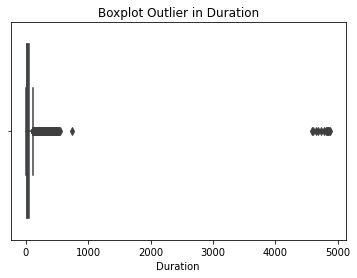

In [29]:
sns.boxplot(df['Duration'])
plt.title('Boxplot Outlier in Duration')
plt.show()

Akan dicari apakah durasi di atas 4000 mempengaruhi 'Claim'

In [30]:
df[(df['Duration']>4000)]

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
87,Others,Airlines,Online,Others,4736,SINGAPORE,0.32,0.09,48,0
4678,Others,Airlines,Online,Others,4857,SINGAPORE,0.32,0.09,48,0
10172,Others,Airlines,Online,Others,4815,SINGAPORE,0.32,0.09,48,0
12140,Others,Airlines,Online,Others,4652,SINGAPORE,0.32,0.09,48,0
19497,Others,Airlines,Online,Others,4881,SINGAPORE,0.13,0.04,48,0
20038,Others,Airlines,Online,Others,4844,SINGAPORE,0.32,0.09,48,0
22215,Others,Airlines,Online,Others,4580,SINGAPORE,0.32,0.09,48,0
25606,Others,Airlines,Online,Others,4685,SINGAPORE,0.32,0.09,48,0
28032,Others,Airlines,Online,Others,4829,SINGAPORE,0.32,0.09,48,0
37207,Others,Airlines,Online,Others,4609,SINGAPORE,0.32,0.09,48,0


Durasi di atas 4000 tidak ada yang Claim asuransi, sehingga akan drop baris yang 'Duration' lebih dari 4000

In [31]:
df.drop(df[df['Duration'] > 4000].index, inplace=True)

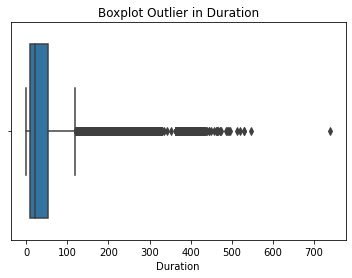

In [32]:
sns.boxplot(df['Duration'])
plt.title('Boxplot Outlier in Duration')
plt.show()

In [33]:
df[(df['Duration']>100) & (df['Claim']==1)]

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
13,C2B,Airlines,Online,Annual Silver Plan,376,SINGAPORE,252.85,63.21,43,1
50,Others,Travel Agency,Online,Others,370,CHINA,204.60,132.99,39,1
102,EPX,Travel Agency,Online,2 way Comprehensive Plan,156,JAPAN,26.00,0.00,36,1
695,C2B,Airlines,Online,Others,370,SINGAPORE,333.00,83.25,30,1
1087,C2B,Airlines,Online,Annual Silver Plan,364,SINGAPORE,216.00,54.00,42,1
...,...,...,...,...,...,...,...,...,...,...
42850,C2B,Airlines,Online,Bronze Plan,116,SINGAPORE,53.50,13.38,36,1
43412,C2B,Airlines,Online,Others,373,SINGAPORE,333.00,83.25,45,1
43554,C2B,Airlines,Online,Annual Silver Plan,364,SINGAPORE,252.85,63.21,30,1
43560,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,252.85,63.21,47,1


Walaupun di Boxplot, data Durasi lebih dari 100 terdeteksi sebagai outliers, data tersebut akan tetap dipakai untuk machine learning karena terdapat Claim kelas 1

#### 2.2 Feature `Net Sales`

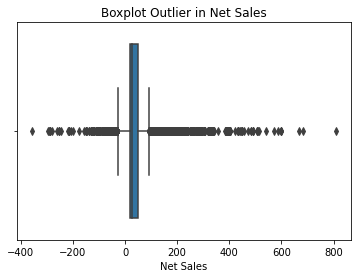

In [34]:
sns.boxplot(df['Net Sales'])
plt.title('Boxplot Outlier in Net Sales')
plt.show()

Data `Net Sales` memiliki range nilai yang negatif, untuk pengolahan data akan digunakan data `Net Sales` yang positif mulai dari 0 hingga max 

In [35]:
df.drop(df[df['Net Sales'] < 0].index, inplace = True)

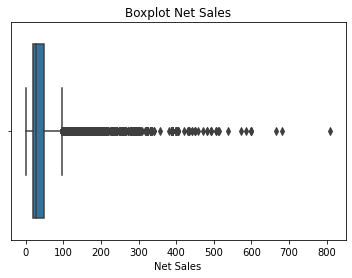

In [36]:
sns.boxplot(df['Net Sales'])
plt.title('Boxplot Net Sales')
plt.show()

Walaupun data `Net Sales` di atas 100 terdeteksi sebagai outliers, namun tetap digunakan untuk training model karena masih masuk akal data `Net Sales` selama bernilai positif

#### 2.3 Feature `Commision (in value)`

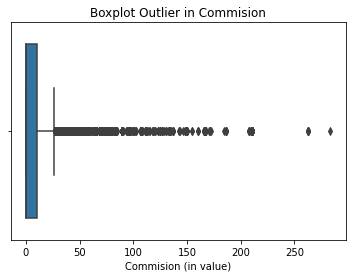

In [37]:
sns.boxplot(df['Commision (in value)'])
plt.title('Boxplot Outlier in Commision')
plt.show()

Walaupun data `Commision (in value)` di atas terdeteksi sebagai outliers, namun tetap digunakan untuk training model karena masih masuk akal data `Commision (in value)` selama bernilai positif

#### 2.4 Feature `Age`

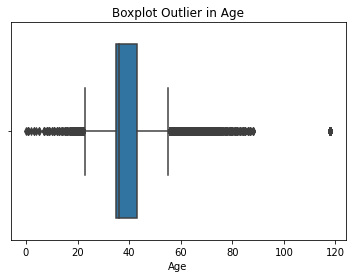

In [38]:
sns.boxplot(df['Age'])
plt.title('Boxplot Outlier in Age')
plt.show()

In [39]:
df[(df['Age']>100) & (df['Claim']==1)]

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
5398,Others,Airlines,Online,Others,25,INDIA,78.0,31.20,118,1
11377,EPX,Travel Agency,Offline,2 way Comprehensive Plan,20,AUSTRALIA,37.0,0.00,118,1
15158,EPX,Travel Agency,Offline,Others,18,CHINA,33.0,0.00,118,1
24732,Others,Airlines,Online,Others,81,INDIA,124.0,49.60,118,1
32456,Others,Travel Agency,Offline,Others,15,THAILAND,29.0,9.57,118,1
35061,Others,Airlines,Online,Others,51,INDIA,78.0,31.20,118,1
43856,Others,Airlines,Online,Others,10,INDIA,50.0,20.00,118,1


Data `Age` yang lebih dari 100 terdeteksi sebagai outliers, diasumsikan typo sehingga akan diubah menjadi mean akan tetap digunakan karena 'Claim' nya kelas 1

In [40]:

df.loc[df["Age"]>100, "Age"] = df["Age"].mean()

In [41]:
df.shape

(43832, 10)

Data asal terdiri dari 44328 baris dan 11 kolom lalu tereduksi menjadi 43832 baris dan 10 kolom setelah drop nan dan outliers yang tidak perlu diikutkan dalam training model

In [42]:
dataDesc=[]
for i in df.columns:
    dataDesc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round((((df[i].isna().sum())/len(df))*100),2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values
    ])

pd.DataFrame(dataDesc, columns=[
    'Data Features',
    'Data Types',
    'Null',
    'Null Percentage',
    'Unique',
    'Unique Sample'
])

,Data Features,Data Types,Null,Null Percentage,Unique,Unique Sample
0,Agency,object,0,0.0,4,"[C2B, Others]"
1,Agency Type,object,0,0.0,2,"[Airlines, Travel Agency]"
2,Distribution Channel,object,0,0.0,2,"[Offline, Online]"
3,Product Name,object,0,0.0,6,"[2 way Comprehensive Plan, Silver Plan]"
4,Duration,int64,0,0.0,423,"[27, 416]"
5,Destination,object,0,0.0,137,"[SPAIN, SWITZERLAND]"
6,Net Sales,float64,0,0.0,884,"[68.49, 34.78]"
7,Commision (in value),float64,0,0.0,912,"[3.76, 1.2]"
8,Age,float64,0,0.0,89,"[9.0, 73.0]"
9,Claim,int64,0,0.0,2,"[0, 1]"


## Save file new format

Simpan data yang telah dibersihkan nan value dan diperbarui kolom kategorinya ke dalam file baru berformat csv

In [46]:
df.to_csv('train.csv', index=False)

In [47]:
df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.0,57.0,0
1,EPX,Travel Agency,Online,Others,4,MALAYSIA,10.0,0.0,33.0,0
2,Others,Airlines,Online,Others,19,INDIA,22.0,7.7,26.0,0
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.0,59.0,0
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.0,28.0,0
